# (2) [Challenge] Ground state energy for molecule and spin system with Variational Quantum Algorithms and Trotterization.

Variational Quantum Algorithms (VQAs) are a class of hybrid quantum-classical algorithms. These algorithms leverage quantum circuits to accelerate computations while utilizing a classical optimizer to iteratively adjust the parameters of the circuit, seeking to minimize a cost function and ultimately find the correct solution.

(a) The calculation of molecular properties is crucial in scientific and technological fields, such as chemistry and the pharmaceutical industry. In particular, the ground state energy of a molecule provides valuable insights into its properties, including stability and reactivity.

You must implement a function in Pennylane that simulates the Variational Quantum Eigensolver (VQE). This function should take as input a six-entry array of floating-point numbers, representing the $x$, $y$, and $z$ coordinates of two hydrogen atoms. The first three entries correspond to the coordinates of the first hydrogen atom, and the remaining three entries represent the coordinates of the second hydrogen atom. The function should return the ground state energy of the molecule. Also explain why the Pauli-Z is necessary in Jordan-Wigner transformation.

**Observation:** Explicitly define the STO-3G basis function set, multiplicity=1, charge=0, and Jordan-Wigner mapping in the code.


## Solution

First we will install and import the libraries needed:

In [1]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.0 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as pnp # We will import the Pennylane Version of np to perform differentialization
from numbers import Real

In [3]:
#lets define a function that will receive the spatial coordinates

def H2_VQE_routine(x1: Real, y1: Real, z1: Real, x2 : Real, y2 : Real, z2 : Real) -> Real:

  #1 step: first we define the molecules to utilize, in this case, the H2 molecule:
  atomic_symbols = ['H', 'H']

  #and define the spatial coordinates of it
  coordinates = pnp.array([[x1, y1, z1], [x2, y2, z2]])

  #define the Hamiltonian of the problem
  molecule= qml.qchem.Molecule(symbols= atomic_symbols,
                               coordinates= coordinates,
                               charge= 0,
                               mult= 1,
                               basis_name= 'sto-3g')

  #now we map the hamiltonian to the qubtis utilizing the JW mapping:
  H2mol, qubits = qml.qchem.molecular_hamiltonian(molecule= molecule,
                                                  mapping= 'jordan_wigner')

  wires = range(qubits) #the n° of qubits that our circuit will need

  #the n° of electrons that our system will requiered.
  num_electrons = int(pnp.ceil(qubits / 2)) #only valid if utilizing the JW mapping

  num_orbitals = qubits #n° of orbitals to consider

  #now, we will generate the most general case of excitations

  #this is the list of all possible single and doubles excitations possible that
  #the electrons can perform between the orbitals
  #higher level of excitantions can be done in the real world, but are waaay less probable to occur

  singles, doubles = qml.qchem.excitations(num_electrons, num_orbitals)
  excitations = singles + doubles

  #now we will parametrized the quantum circuit that will be
  #measuring the Exp. Value of our Molecular Hamiltonian

#Here we will utilize lightning qubits to really really fast simulations
  dev = qml.device('default.qubit', wires= qubits)

  @qml.qnode(dev)
  def parametrized_expval(theta, initial_state):

    qml.BasisState(initial_state, wires= wires)

    for i, excitation in enumerate(excitations):

      if len(excitation) == 4:
        qml.DoubleExcitation(theta[i], wires= excitation)

      else:
        qml.SingleExcitation(theta[i], wires= excitation)

    return qml.expval(H2mol)

  #Now we initialize the initial state of the system
  hf_H2 = qml.qchem.hf_state(num_electrons, qubits)


  #now we will define the optimizer and the initial point
  opt = qml.GradientDescentOptimizer(stepsize= 0.02)
  theta = pnp.random.random(size= len(excitations), requires_grad= True) * (2 * pnp.pi) #random

  #now we will perform the iterations of the optimization routine in order to
  #Achieve the Ground State Energy

  # In order to obtain Chemical acurracy, which is settle down to be of 0.0016 Ha
  # We will not stop until our final answer achieve a resolution of 0.00001 Ha
  delta_E = 10
  energy_results = []
  Chem_accuracy = 1e-5
  while abs(delta_E) > Chem_accuracy:
    theta, prev_energy = opt.step_and_cost(parametrized_expval,
                                           theta,
                                           initial_state= hf_H2)

    new_energy = parametrized_expval(theta, initial_state= hf_H2)
    delta_E = new_energy - prev_energy
    energy_results.append(new_energy)
    if len(energy_results) % 5 == 0:
        print(f"Step = {len(energy_results)},  Energy = {new_energy:.6f} Ha")
  print(f"Starting with HF state took {len(energy_results)} iterations until convergence.")
  return energy_results[-1]




In [4]:
print(f'final energy: {H2_VQE_routine(0, 0, 0, 0, 0, 1)}')

Step = 5,  Energy = 0.004826 Ha
Step = 10,  Energy = 0.002421 Ha
Step = 15,  Energy = -0.000126 Ha
Step = 20,  Energy = -0.002837 Ha
Step = 25,  Energy = -0.005733 Ha
Step = 30,  Energy = -0.008834 Ha
Step = 35,  Energy = -0.012165 Ha
Step = 40,  Energy = -0.015748 Ha
Step = 45,  Energy = -0.019609 Ha
Step = 50,  Energy = -0.023772 Ha
Step = 55,  Energy = -0.028264 Ha
Step = 60,  Energy = -0.033111 Ha
Step = 65,  Energy = -0.038341 Ha
Step = 70,  Energy = -0.043981 Ha
Step = 75,  Energy = -0.050060 Ha
Step = 80,  Energy = -0.056604 Ha
Step = 85,  Energy = -0.063642 Ha
Step = 90,  Energy = -0.071199 Ha
Step = 95,  Energy = -0.079301 Ha
Step = 100,  Energy = -0.087971 Ha
Step = 105,  Energy = -0.097229 Ha
Step = 110,  Energy = -0.107095 Ha
Step = 115,  Energy = -0.117582 Ha
Step = 120,  Energy = -0.128701 Ha
Step = 125,  Energy = -0.140460 Ha
Step = 130,  Energy = -0.152857 Ha
Step = 135,  Energy = -0.165891 Ha
Step = 140,  Energy = -0.179549 Ha
Step = 145,  Energy = -0.193818 Ha
Step = 

In [5]:
#lets define a function that will receive the coo

def H2_VQE_routine_faster(x1: Real, y1: Real, z1: Real, x2 : Real, y2 : Real, z2 : Real) -> Real:

  #1 step: first we define the molecules to utilize, in this case, the H2 molecule:
  atomic_symbols = ['H', 'H']
  #and define the spatial coordinates of it
  coordinates = pnp.array([[x1, y1, z1], [x2, y2, z2]])

  #define the Hamiltonian of the problem
  molecule= qml.qchem.Molecule(symbols= atomic_symbols,
                               coordinates= coordinates,
                               charge= 0,
                               mult= 1,
                               basis_name= 'sto-3g')

  #now we map the hamiltonian to the qubtis utilizing the JW mapping:
  H2mol, qubits = qml.qchem.molecular_hamiltonian(molecule= molecule,
                                                  mapping= 'jordan_wigner')

  wires = range(qubits) #the n° of qubits that our circuit will need

  #the n° of electrons that our system will requiered.
  num_electrons = int(pnp.ceil(qubits / 2)) #only valid if utilizing the JW mapping

  num_orbitals = qubits #n° of orbitals to consider

  #now, we will generate the most general case of excitations

  #this is the list of all possible single and doubles excitations possible that
  #the electrons can perform between the orbitals
  #higher level of excitantions can be done in the real world, but are waaay less probable to occur

  singles, doubles = qml.qchem.excitations(num_electrons, num_orbitals)
  excitations = singles + doubles

  #now we will parametrized the quantum circuit that will be
  #measuring the Exp. Value of our Molecular Hamiltonian

#Here we will utilize lightning qubits to really really fast simulations
  dev = qml.device('lightning.qubit', wires= qubits)

  @qml.qnode(dev)
  def parametrized_expval(theta, initial_state):

    qml.BasisState(initial_state, wires= wires)

    for i, excitation in enumerate(excitations):

      if len(excitation) == 4:
        qml.DoubleExcitation(theta[i], wires= excitation)

      else:
        qml.SingleExcitation(theta[i], wires= excitation)

    return qml.expval(H2mol)

  #Now we initialize the initial state of the system
  hf_H2 = qml.qchem.hf_state(num_electrons, qubits)


  #now we will define the optimizer and the initial point
  opt = qml.GradientDescentOptimizer(stepsize= 0.04)
  theta = pnp.random.random(size= len(excitations), requires_grad= True) * (2 * pnp.pi) #random

  #now we will perform the iterations of the optimization routine in order to
  #Achieve the Ground State Energy

  # In order to obtain Chemical acurracy, which is settle down to be of 0.0016 Ha
  # We will not stop until our final answer achieve a resolution of 0.00001 Ha
  delta_E = 10
  energy_results = []
  Chem_accuracy = 1e-5
  while abs(delta_E) > Chem_accuracy:
    theta, prev_energy = opt.step_and_cost(parametrized_expval,
                                           theta,
                                           initial_state= hf_H2)

    new_energy = parametrized_expval(theta, initial_state= hf_H2)
    delta_E = new_energy - prev_energy
    energy_results.append(new_energy)
   # if len(energy_results) % 5 == 0:
        #print(f"Step = {len(energy_results)},  Energy = {new_energy:.6f} Ha")
  #print(f"Starting with HF state took {len(energy_results)} iterations until convergence.")
  return energy_results[-1]




In [6]:
print(H2_VQE_routine_faster(0, 0, 0, 0, 0, 1))

-1.07870824033614


# Extra: Plotting the energy values for diferent interatomic distance

With this new function, we can generate an energy curve for several inter atomic distances in order to calculate the equilibrium
Configuration of the molecule:

In [7]:
import matplotlib.pyplot as plt
import numpy as np


#we define how the arrange we will be plotted
distances = np.arange(0.2, 2, 0.1)
energies = np.zeros_like(distances)

#compute the energies for several values of r
for i, ri in enumerate(distances):
    energy = H2_VQE_routine_faster(0, 0, 0, 0, 0, ri)
    energies[i] = energy



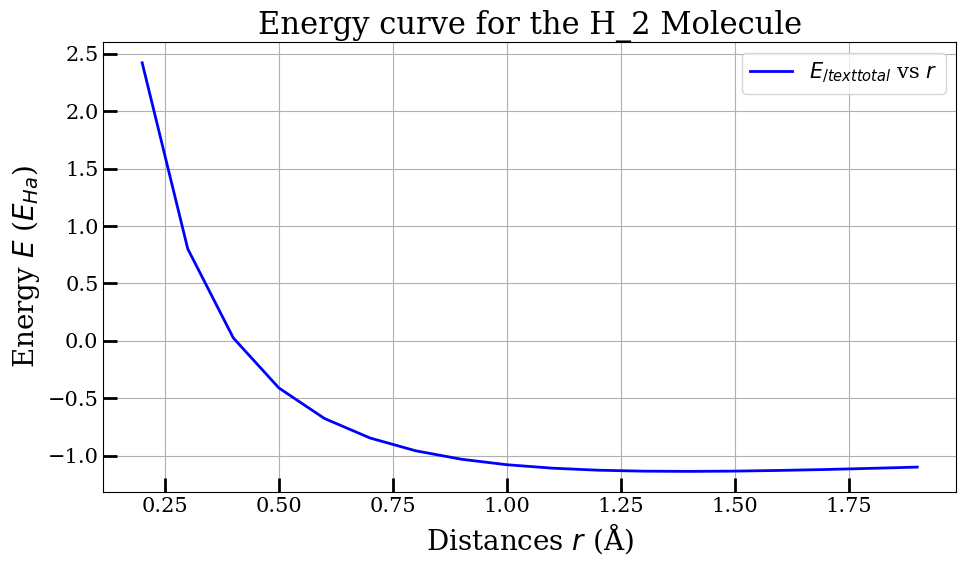

In [9]:
#########################
# Personalización del gráfico

plt.rcParams.update({
    "font.family": "serif",  # Usar fuentes serif
    "font.sans-serif": "Helvetica",  # Usar Helvetica para texto sans-serif
    "font.size": 18  # Ajustar el tamaño de la fuente
})

# Crear el gráfico
fig, ax = plt.subplots(figsize=(10, 6))  # Tamaño grande para mejorar la legibilidad

# Plot de las energías en función de las distancias
ax.plot(distances, energies, color='b', lw=2, label=r'$E_{ /text{total}}$ vs $r$')  # Línea azul

# Personalizar los ejes
ax.set_xlabel(r'Distances $r$ (Å)', fontsize=20)  # Etiqueta del eje X
ax.set_ylabel(r'Energy $E$ ($E_{Ha}$)', fontsize=20)  # Etiqueta del eje Y
ax.grid(True)

# Establecer los ticks
ax.tick_params(axis='both', which='major', length=10, width=2, labelsize=15, direction='in', color='black')
ax.tick_params(axis='both', which='minor', length=5, width=1, labelsize=12, direction='in', color='black')

# Mostrar el gráfico con la leyenda
ax.legend(fontsize=15)

# Título del gráfico
ax.set_title('Energy curve for the H_2 Molecule', fontsize=22)

# Ajustar el espacio para que todo el texto y elementos sean visibles
plt.tight_layout()

# Guardar la figura como SVG
plt.savefig('energy_vs_distance.svg', format='svg')

# Mostrar el gráfico
plt.show()

The reason that WHY it is necessary to add the $\sigma_z$ spin operators, it is because it is necesary that the transformation performed is, indeed, an isomorfism from the $\mathcal{SO}(2n) \iff \mathcal{SU}(2)$

In a more easy way to visualize this, we now that the fermionic anhihilation and creation operators are defined under the following algebraic rules:

$$
\{a_i, a_j^\dagger\} \equiv a_i a_j^\dagger + a_j^\dagger a_i = \delta_{ij},
$$

$$
\{a_i^\dagger, a_j^\dagger\} = \{a_i, a_j\} = 0.
$$

If we naively defined the transformation as:

$$
a_k = \mathbb{I}_{k-1} \otimes ( X -i Y ) \otimes \mathbb{I}_{N - k} = \mathbb{I}_{k-1} \otimes |0 \rangle \langle 1| \otimes \mathbb{I}_{N - k}
$$
$$
a_j^{\dagger} = \mathbb{I}_{j-1} \otimes ( X +i Y ) \otimes \mathbb{I}_{N - j} =  \mathbb{I}_{k-1} \otimes |1 \rangle \langle 0| \otimes \mathbb{I}_{N - k}
$$


we can observe that, if $k \neq j$ and w.l.g, $j < k$:

$$
\{a_k, a_j^\dagger\} = (\mathbb{I}_{k-1} |0 \rangle \langle 1| \otimes \mathbb{I}_{N - k}) (\mathbb{I}_{k-1} |1 \rangle \langle 0| \otimes \mathbb{I}_{N - k}) +
(\mathbb{I}_{k-1} |1 \rangle \langle 0| \otimes \mathbb{I}_{N - k})(\mathbb{I}_{k-1} |0 \rangle \langle 1| \otimes \mathbb{I}_{N - k})
$$
$$
\to \mathbb{I}_{j - 1} \otimes | 0 \rangle \langle 1 | \otimes \mathbb{I}_{k - j - 1} \otimes | 1 \rangle \langle 0 | \otimes \otimes \mathbb{I}_{N - j - k}
+ \mathbb{I}_{j - 1} \otimes | 0 \rangle \langle 1 | \otimes \mathbb{I}_{k - j - 1} \otimes | 1 \rangle \langle 0 | \otimes \otimes \mathbb{I}_{N - j - k}
$$

$$
\to 2 \mathbb{I}_{j - 1} \otimes | 0 \rangle \langle 1 | \otimes \mathbb{I}_{k - j - 1} \otimes | 1 \rangle \langle 0 | \otimes \otimes \mathbb{I}_{N - j - k} \neq 0
$$

Which does not satisfies the $\{a_i, a_j^\dagger\} = \delta_{ij}$ condition.

But if we define:

$$
a_k = \Z^{\otimes k-1} \otimes ( X -i Y ) \otimes \mathbb{I}_{N - k} = \Z^{\otimes k-1} |0 \rangle \langle 1| \otimes \mathbb{I}_{N - k}
$$
and
$$
a_j^{\dagger} = \Z^{\otimes j-1} \otimes ( X +i Y ) \otimes \mathbb{I}_{N - j} =  \Z^{\otimes j-1} |1 \rangle \langle 0| \otimes \mathbb{I}_{N - j}
$$

For sake of simplicity, we will write $a_k = Z^{k-1}\sigma_-I^{N-k}$ and $a_j^{\dagger} =  Z^{j-1}\sigma_+I^{N-j}$

Thus, by calculating the anticonmutator and w.l.g $ 0 \leq j < k$:

$$
\{ a_k, a_j^\dagger  \} = (Z^{k-1}\sigma_-I^{N-k})(Z^{j-1}\sigma_+I^{N-j}) + (Z^{j-1}\sigma_+I^{N-j})(Z^{k-1}\sigma_-I^{N-k})
$$

$$
\to ((Z^2 )^{j-1})(Z \sigma_+)(Z^{ (k-1) - (j+1)})(\sigma_- 1)(I^{N-k}) + (Z^2 )^{j-1}(\sigma_+ Z)(Z^{ (k-1) - (j+1)})(\sigma_-)(I^{N-k})
$$

and note that $Z \sigma_+ = (|0\rangle \langle 0| - |1 \rangle \langle 1|) |1 \rangle \langle 0| = -|1 \rangle \langle 0 | = -\sigma_+ $ and $ \sigma_+ Z = |1 \rangle \langle 0| (|0\rangle \langle 0| - |1 \rangle \langle 1|) = |1 \rangle \langle 0| = \sigma_+ $ and $Z^2 = I$

$$
- \to I^{j-1} (\sigma_+)(Z^{ (k-1) - (j+1)})(\sigma_- 1)(I^{N-k}) + (I )^{j-1}(\sigma_+)(Z^{ (k-1) - (j+1)})(\sigma_-)(I^{N-k}) = 0
$$

$$
\to \{ a_k, a_j^\dagger  \} = 0
$$

if $j \neq k$

And for the other relationships:

if $j = k \to \sigma_+ \sigma_- = |1 \rangle \langle 0| 0 \rangle \langle 1 | = |1 \rangle \langle 1|$ and $\sigma_- \sigma_+ = |0 \rangle \langle 1| 1 \rangle \langle 0 | = |0 \rangle \langle 0|$
and thus:

$$
\{ a_j, a_j^\dagger \} = (Z^2)^{j-1} (\sigma_+ \sigma_- ) (I)^{N-j} + (Z^2)^{j-1} (\sigma_- \sigma_+ ) (I)^{N-j}
$$

$$
\to (Z^2)^{j-1} ( |0 \rangle \langle 0|  + |1 \rangle \langle 1|) (I)^{N-j} = I^{N}
$$

$$
\to \{ a_j, a_j^\dagger \} = I^{N}
$$

and for $\{a_i^\dagger, a_j^\dagger\} = \{a_i, a_j\} = 0.$ We occupie the fact that if $j= k \to \sigma_+^2 = \sigma_-^2 = 0$ (It can go up more than one time) and trivial. And if $j \neq k \to$ there will be a $Z\sigma_\pm$ and a $\sigma_\pm Z$ term in witch will be add up a minus sign to the anticonmutator terms and it's obtained the 0 operator.

QED.